In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import glob
import metpy
from metpy import calc
from metpy.units import units

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [21]:
inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/pressure_levels/ERA5_2012_06_27_pl.nc'

In [22]:
ds = xr.open_dataset(inpath)

In [23]:
ds = uda.flip_lat(ds)

In [24]:
topo = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg.nc')
topo = uda.flip_lat(topo)
topo = topo['z'].sel(longitude=slice(-78,-51), latitude=-22).squeeze()  #-69

KeyError: -22.0

In [7]:
slices = ds.sel(longitude=slice(-78,-51), latitude=-22)

In [8]:
print('Current hour:', slices['time.hour']-5)

Current hour: <xarray.DataArray 'hour' (time: 8)>
array([-5, -2,  1,  4,  7, 10, 13, 16])
Coordinates:
    latitude  float32 -12.0
  * time      (time) datetime64[ns] 2012-06-27 ... 2012-06-27T21:00:00


In [9]:
slices['time.hour']

<xarray.DataArray 'hour' (time: 8)>
array([ 0,  3,  6,  9, 12, 15, 18, 21])
Coordinates:
    latitude  float32 -12.0
  * time      (time) datetime64[ns] 2012-06-27 ... 2012-06-27T21:00:00

In [10]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 77)>
array([-18.  , -17.75, -17.5 , -17.25, -17.  , -16.75, -16.5 , -16.25, -16.  ,
       -15.75, -15.5 , -15.25, -15.  , -14.75, -14.5 , -14.25, -14.  , -13.75,
       -13.5 , -13.25, -13.  , -12.75, -12.5 , -12.25, -12.  , -11.75, -11.5 ,
       -11.25, -11.  , -10.75, -10.5 , -10.25, -10.  ,  -9.75,  -9.5 ,  -9.25,
        -9.  ,  -8.75,  -8.5 ,  -8.25,  -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,
        -6.75,  -6.5 ,  -6.25,  -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,
        -4.5 ,  -4.25,  -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,
        -2.25,  -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
         0.  ,   0.25,   0.5 ,   0.75,   1.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.25 0.5 0.75 1.0
Attributes:
    units:      degrees_north
    long_name:  latitude

In [11]:
gp = slices['z']

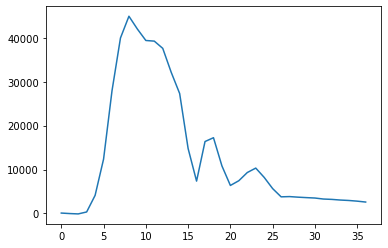

In [12]:
plt.plot(topo)

In [13]:
gp = gp.where(gp>topo)

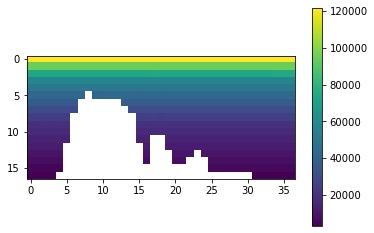

In [14]:
plt.imshow(gp.isel(time=0))
plt.colorbar()

In [15]:
slices = slices.where(gp>topo)

In [16]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002, headwidth=7)
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=1.7, linestyles='solid' )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.0f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp

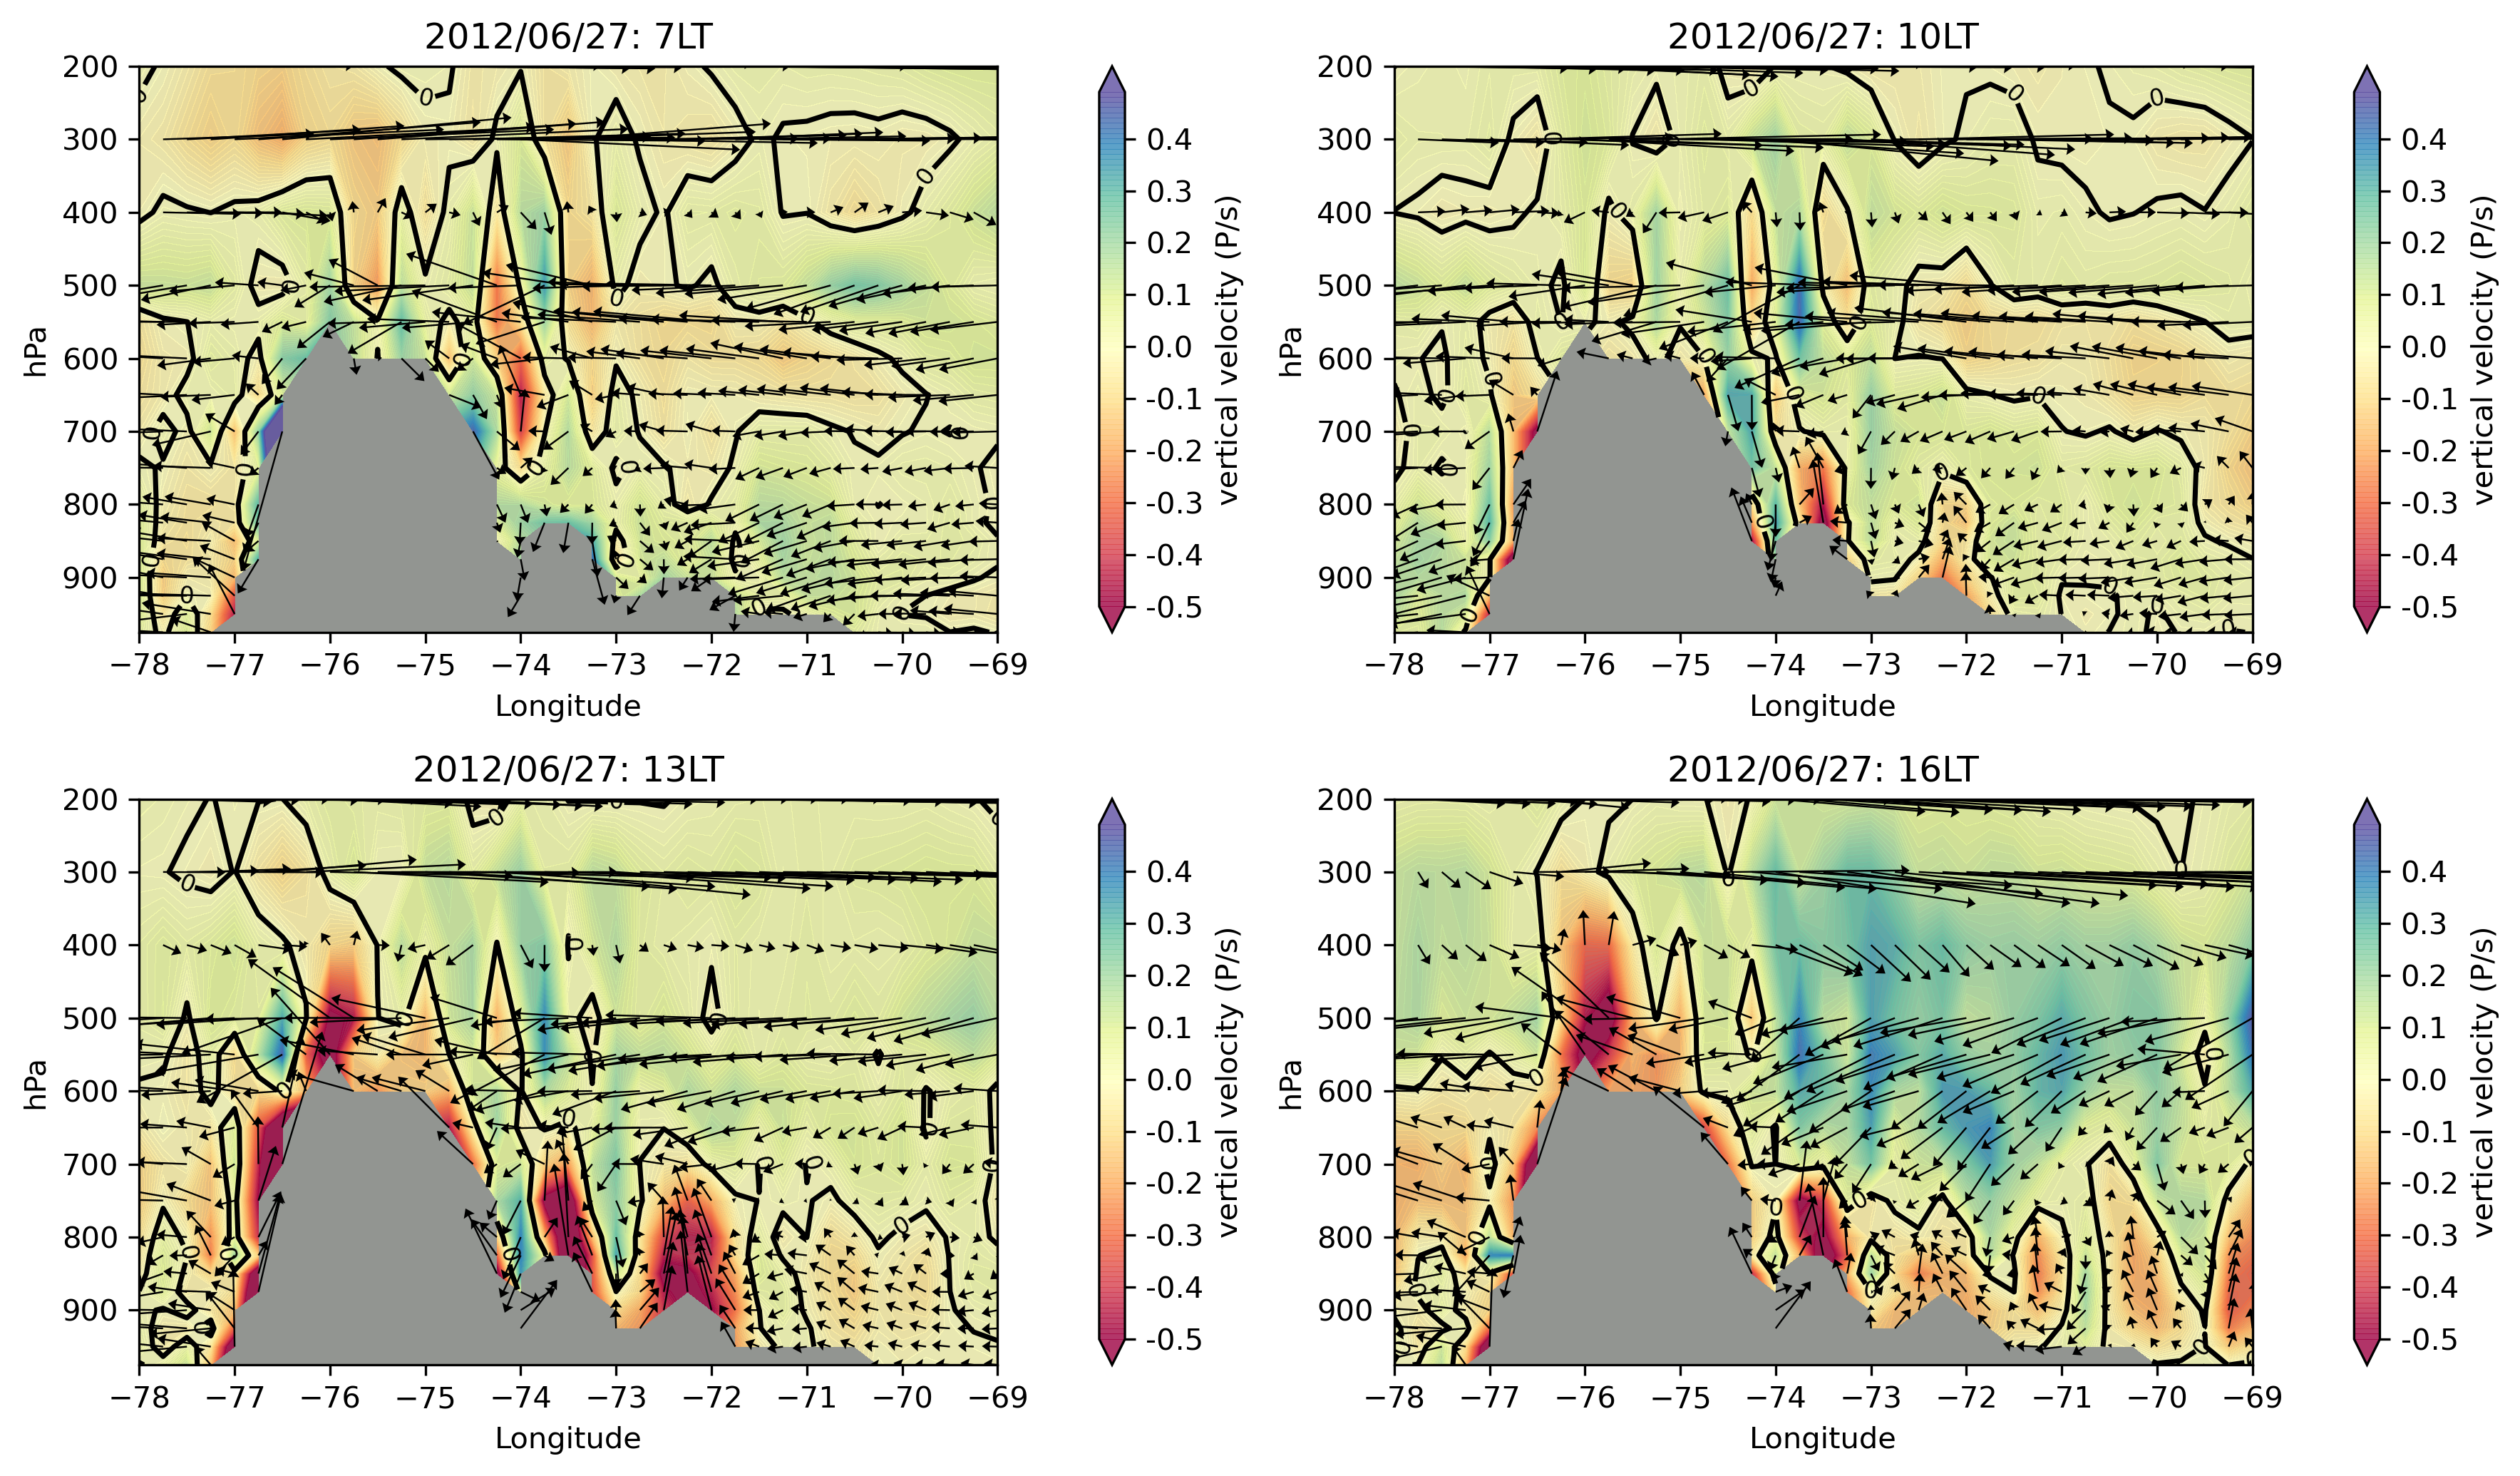

In [451]:
f = plt.figure(figsize=(12,7), dpi=300)

for ids, tt in enumerate([4,5,6,7]):
    
    sli = slices.isel(time=tt)

    p = units.Quantity(sli.level.values, 'hPa')

    t = units.Quantity(sli['t'].values, 'K')
    q = units.Quantity(sli['q'].values, 'kg/kg')


    dewp = calc.dewpoint_from_specific_humidity(q.T, t.T, p).T
    theta_e = calc.equivalent_potential_temperature(p,t.T,dewp.T).T
    theta = calc.potential_temperature(p,t.T).T

    # "current zonal wind" wind vectors
    vano = sli['u']
    wano = sli['w']*(-5)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = sli.longitude[sarrow::st]
    yquiv = sli.level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

    # temperature and moisture check
    data = (np.array(theta.data).T-np.nanmean(theta.data, axis=1)).T
    data2 = sli['w']
    
    ax = f.add_subplot(2,2,ids+1)
    contour = {'data' : data2, 'x' :sli.longitude, 'y' : sli.level, 'levels' : np.arange(0,1), 'colours' : 'k'}
    draw_cross(ax, data2, sli.longitude, sli.level, ylabel = 'hPa', xlabel='Longitude',cmap='Spectral', quiver=qin, contour=contour, cbar_label='vertical velocity (P/s)', levels=np.arange(-0.5,0.5, 0.01), title='2012/06/27: '+str(sli['time.hour'].values-5) + 'LT')
    ax.set_facecolor('xkcd:grey')
    plt.tight_layout()
   # f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/topo/drySeason_AndesCross_circulation_june.jpg')
